<a href="https://colab.research.google.com/github/tevolve/Machine-Learning-/blob/main/transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Passo 1: Configuração do Ambiente e Importação de Bibliotecas**

In [ ]:

# Importando as bibliotecas necessárias
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

**Passo 2: Download do Dataset com TensorFlow Datasets**

Substituindo o link quebrado pela função tensorflow_datasets.load.

In [ ]:

# Carregando o dataset Cats vs Dogs do TensorFlow Datasets
(raw_train, raw_validation), metadata = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],  # 80% treino e 20% validação
    as_supervised=True,  # Retorna tuplas (imagem, rótulo)
    with_info=True
)

# Tamanho da imagem
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Função para pré-processar as imagens
def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Redimensiona as imagens
    image = image / 255.0  # Normaliza os pixels (0 a 1)
    return image, label

# Aplicando o pré-processamento e preparando os datasets
train = raw_train.map(format_image).shuffle(1000).batch(BATCH_SIZE)
validation = raw_validation.map(format_image).batch(BATCH_SIZE)

**Passo 3: Visualização do Dataset**

Visualização algumas imagens para garantir que o dataset foi carregado corretamente.

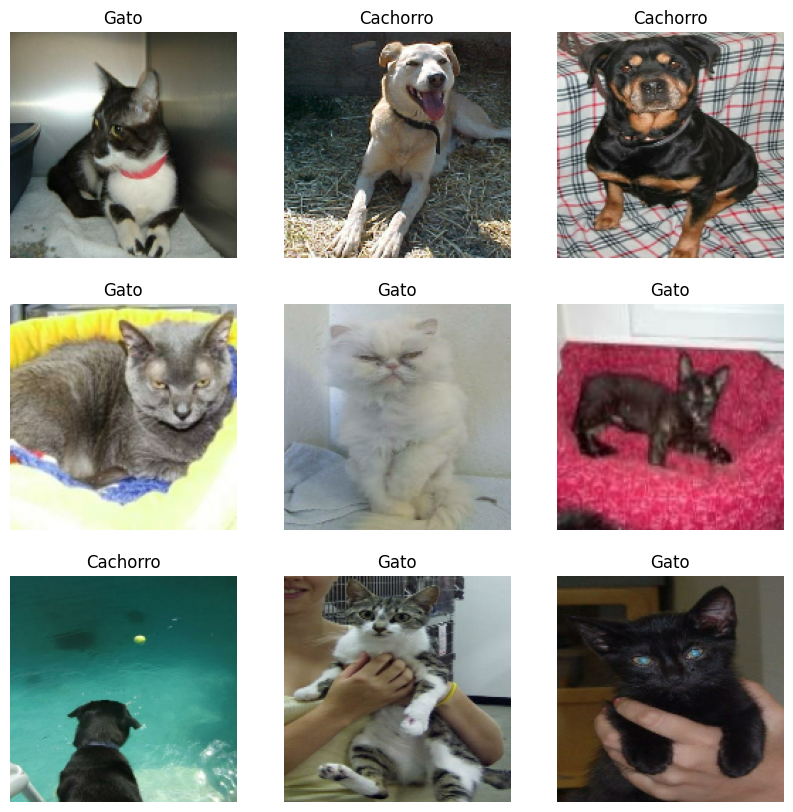

In [ ]:

# Visualizando algumas imagens do dataset
for image, label in train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.title("Gato" if label[i] == 0 else "Cachorro")
        plt.axis("off")
    plt.show()

**Passo 4: Construção do Modelo com Transfer Learning**

Aqui, utilizei o MobileNetV2 ***(MobileNetV2 é uma arquitetura de rede neural projetada para ser leve e eficiente, especialmente em dispositivos móveis e com recursos limitados. Ela é usada em tarefas como classificação de imagens, detecção de objetos e segmentação.

Sua principal inovação é usar convoluções separáveis por profundidade, que tornam os cálculos mais rápidos e com menos memória, e blocos residuais invertidos, que ajudam a preservar informações importantes durante o treinamento.)*** como base para Transfer Learning. O modelo será adaptado para classificar imagens entre duas classes: gatos (0) e cachorros (1).

In [ ]:
# Carregando o modelo base pré-treinado MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(160, 160, 3))

# Congelando os pesos da base pré-treinada
base_model.trainable = False

# Construindo o modelo com camadas adicionais
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)  # Congelando a base
x = GlobalAveragePooling2D()(x)  # Reduz para um vetor 1D
x = Dropout(0.2)(x)  # Adicionando regularização
outputs = Dense(1, activation="sigmoid")(x)  # Camada de saída (classificação binária)
model = Model(inputs, outputs)

# Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="binary_crossentropy",
              metrics=["accuracy"])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Passo 5: Treinamento do Modelo**

Treinando o modelo com o dataset preparado.

Obs: Poderá alterar o número de épocas para um número menor caso queira apenas fazer teste.

In [ ]:
# Treinando o modelo
history = model.fit(
    train,
    validation_data=validation,
    epochs=10
)

582/582 ━━━━━━━━━━━━━━━━━━━━ 417s 715ms/step - accuracy: 0.9804 - loss: 0.0567 - val_accuracy: 0.9766 - val_loss: 0.0639


**Passo 6: Avaliação e Visualização dos Resultados**

Após o treinamento, avaliação do desempenho do modelo e Visualização das métricas.

In [ ]:
# Avaliando o modelo no conjunto de validação
loss, accuracy = model.evaluate(validation)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Visualizando as curvas de treinamento e validação
plt.plot(history.history["accuracy"], label="Acurácia de Treinamento")
plt.plot(history.history["val_accuracy"], label="Acurácia de Validação")
plt.legend()
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Curva de Acurácia")
plt.show()

plt.plot(history.history["loss"], label="Perda de Treinamento")
plt.plot(history.history["val_loss"], label="Perda de Validação")
plt.legend()
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.title("Curva de Perda")
plt.show()

**Passo 7: Fine-Tuning (Aperfeiçoamento do Modelo - Opcional)**

Se quiser melhorar o desempenho, descongele algumas camadas finais do modelo base para ajustá-las aos dados.

In [ ]:
# Descongelando algumas camadas finais do modelo base
base_model.trainable = True

# Compilando novamente com uma taxa de aprendizado menor
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Taxa de aprendizado reduzida
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Treinamento adicional (fine-tuning)
history_fine = model.fit(
    train,
    validation_data=validation,
    epochs=10
)

**Passo 8: Salvando o Modelo**

Salve o modelo treinado para utilizá-lo posteriormente.

In [ ]:
# Salvando o modelo
model.save("cats_vs_dogs_model.h5")